[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six
import yaml

from collections import Counter, OrderedDict
from joblib import cpu_count, delayed, Parallel
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels, dpi=240, filled=False, ret_image=False):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        image = draw_contours(image, masks[i], labels[i], filled)
    if ret_image:
        return image
    else:
        display_image(image, dpi=dpi)

def display_fluorescence(fluorescence, masks, labels, ret_image=False):
    image = cv2.cvtColor(scale_image(fluorescence), cv2.COLOR_GRAY2RGB)
    if fluorescence.max() == 1:  # if binary image
        sc, fc = {}, {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            image = draw_contours(image, combined_mask & fluorescence, k, filled=True)
            sc[k] = sum(combined_mask.flatten())
            fc[k] = sum((combined_mask & fluorescence).flatten())
        for k in sc:
            print("Class %s (%s): %i/%i (%.2f%%)" %
                  (k, colormap.colors[k], fc[k], sc[k], fc[k]*100/sc[k]))
    else:
        fig, axs = plt.subplots(1, len(np.unique(labels)), figsize=(18,5))
        intensities = scale_image(image_fluorescent, 100)
        fc = {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            axs[k].hist(intensities.flatten()[np.nonzero(combined_mask.flatten())],
                     bins=range(100), color = colormap.colors[k])
            axs[k].set_title("Class %i" % k)
            axs[k].set_xlim([0,100])
    if ret_image:
        return image
    else:
        display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = TSNE(learning_rate='auto', init='pca', random_state=0).fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def draw_contours(image, mask, color_label, filled=False):
    color = np.array(matplotlib.colors.to_rgb(colormap.colors[color_label]))*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    thickness = -1 if filled else 1
    return cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=thickness)

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    # POSSIBLE BUG, VERIFY THAT from_dict DOESN'T INFER WRONG TYPES
    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, param_path, verbosity=0):
    with open(param_path, 'r') as f:
        param_file = yaml.load(f, Loader=yaml.FullLoader)
        mode = param_file['mode']
        params = param_file['params']

    if verbosity:
        print("Using mode '%s'." % mode)
    
    if verbosity and params.get('clipLimit'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    # We are also deliberately not sharpening here
    if params.get('canny_unmasking'):
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, *params.get('canny_unmasking'))
        canny_filled = apply_imfill(apply_closure(canny, 5))
        
    ### IMAGE PREPROCESSING ###
    
    if params.get('invert_image'):
        image = 255 - image

    if params.get('denoise_pre'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params.get('contrast'):
        if verbosity:
            print(("Enhancing contrast by factor of %.2f, with "
                   "offset=%s and preserve_background=%s.") %
                  (params['contrast'], params['offset'], params['preserve_background']))
        image = apply_contrast(image, params['contrast'],
                               params['offset'], params['preserve_background'])
    
    if params.get('clipLimit'):
        if verbosity:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params.get('denoise_post'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])

    if verbosity and params.get('clipLimit'):
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])
    
    ### IMAGE BINARIZATION ###
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbosity:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbosity:
            print("Applying Canny with thresholds %i and %i." %
                  (params['canny_thresh1'], params['canny_thresh2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['canny_thresh1'], params['canny_thresh2'])
    elif mode == "edge_sobel":
        if verbosity:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbosity:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbosity:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_manual":
        if verbosity:
            print("Manually thresholding on values >=%i." % params['manual_threshold'])
        binarized = np.uint8(image >= params['manual_threshold'])
    elif mode == "thresh_otsu":
        if verbosity:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None

    ### IMAGE POSTPROCESSING ###
    
    if params.get('size_thresh'):
        if verbosity:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params.get('canny_unmasking'):
        if verbosity:
            print("Unmasking areas without edges using Canny%s:" % params.get('canny_unmasking'))
        binarized = binarized & canny_filled  # POSSIBLE BUG: CHECK IF CANNY_FILLED IS BINARY
    
    if params.get('border_removal'):
        if verbosity:
            print("Removing border of %i pixels." % params['border_removal'])
        binarized[:params['border_removal'], :] = 0
        binarized[:, :params['border_removal']] = 0
        binarized[-params['border_removal']:, :] = 0
        binarized[:, -params['border_removal']:] = 0
        
    if params.get('closure_ks'):
        if verbosity:
            print("Closing with kernel size of %i." % params['closure_ks'])
        filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
        if verbosity >= 2:
            display_image_array([image, binarized, filled],
                                ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)
        return filled
    else:
        if verbosity >= 2:
            display_image_array([image, binarized],
                                ["Preprocessed", "Binarized"], columns=2, dpi=450)
        return binarized

# Extract mask using grayscale image

In [4]:
image_stack = cv2.imreadmulti('source_images/suspension_colour.tiff',
                              flags=cv2.IMREAD_GRAYSCALE)[1]
image_stack = list(map(scale_image, image_stack))

Using mode 'thresh_adaptive'.
Denoising with intensity 3.
Applying adaptive thresholding with kernel size of 151 and C=8.
Unmasking regions smaller than 40 pixels.
Unmasking areas without edges using Canny[130, 180]:
Removing border of 2 pixels.
Closing with kernel size of 12.


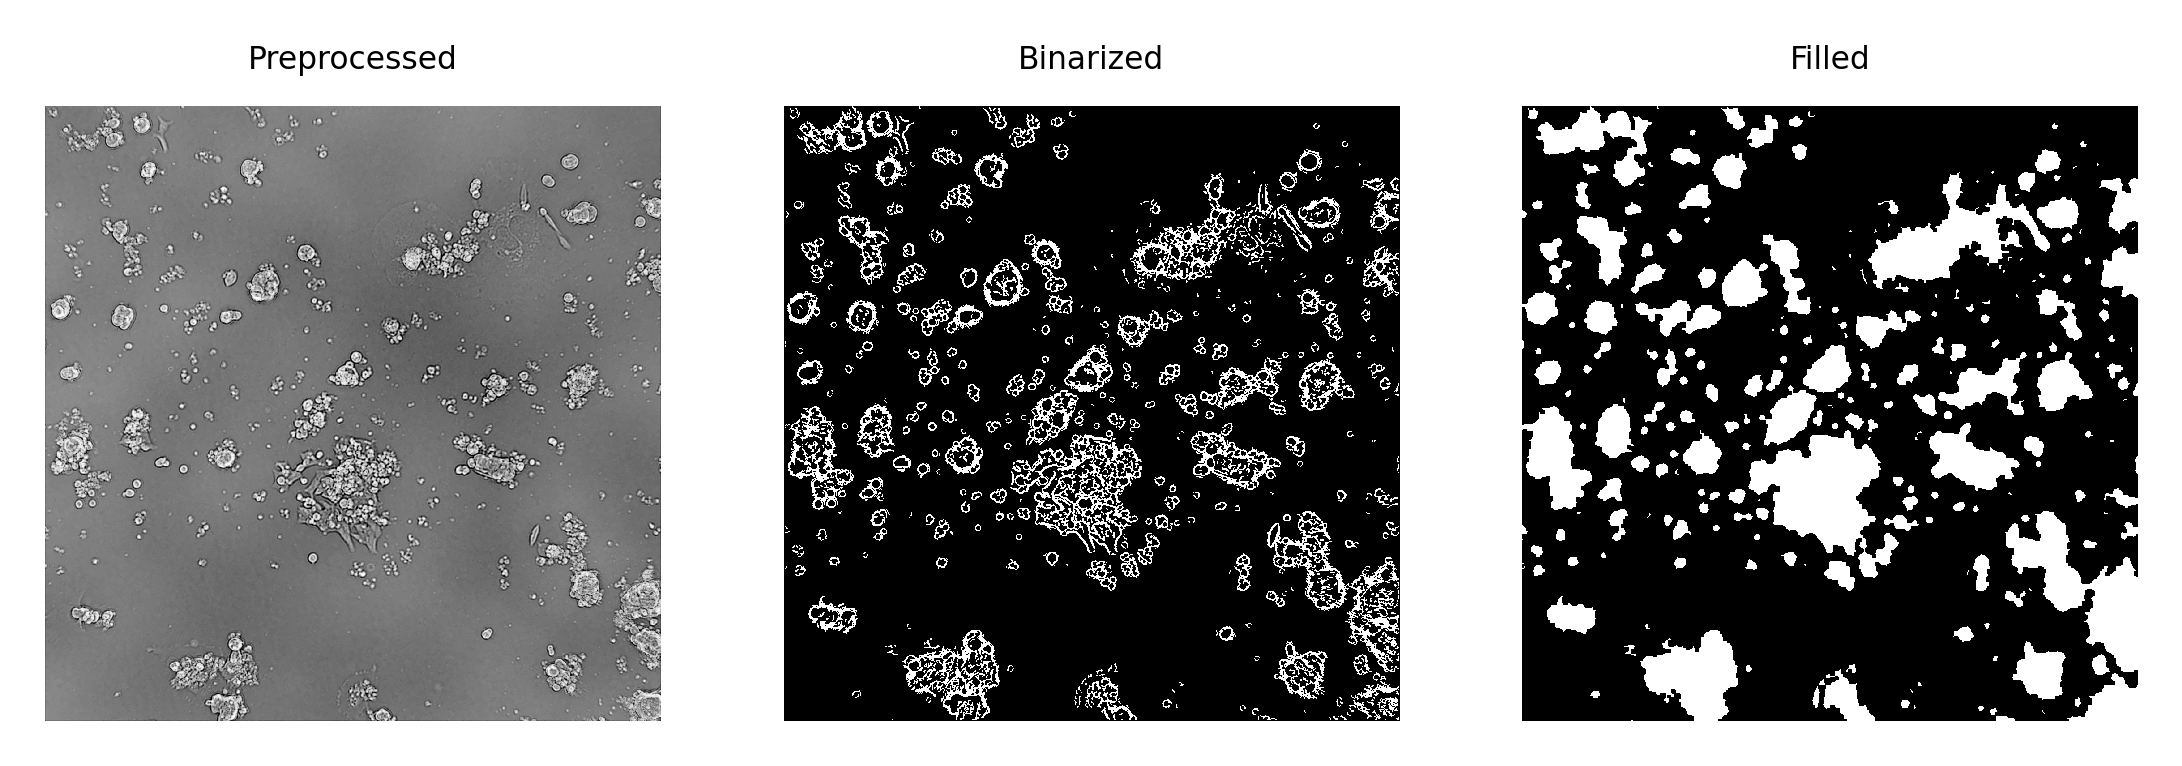

In [5]:
image_gray = image_stack[1]
mask_image = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract features, then scale and reduce dimensions

In [6]:
df, masks = extract_features(image_gray, mask_image)
display(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x    y                                                                     
250  112                      0.541798                        403.139961   
687  42                       0.549822                         85.507103   
35   28                       0.923657                         34.886823   
931  31                       0.519540                         28.100077   
781  90                       0.541036                        124.634093   
...                                ...                               ...   
1796 1931                     0.689518                         28.791026   
1238 1936                     0.906943                         29.949400   
1483 1950                     0.849008                         19.891483   
1524 1960                     0.751963                         24.857261   
1558 1984                     0.257441                         65.756170   

          original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x    y                                                                    
250  112                 380.6691476860188                      37553.5   
687  42                  95.67131231461184                       3015.5   
35   28                 40.607881008493905                        805.5   
931  31                 24.186773244895647                        187.5   
781  90                 120.22063050907694                       5461.5   
...                                    ...                          ...   
1796 1931                31.25699921617557                        432.5   
1238 1936               31.953090617340916                        626.5   
1483 1950               21.095023109728988                        254.5   
1524 1960               25.079872407968907                        332.5   
1558 1984                62.81719509815764                        807.5   

           original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x    y                                                                   
250  112                         218.420480         1871.3839097590358   
687  42                           47.013698          270.4091629284904   
35   28                           32.223460          136.6690475583123   
931  31                           14.599109           77.4558441227157   
781  90                           67.431557          421.8650070512063   
...                                     ...                        ...   
1796 1931                         19.851931          91.11269837220817   
1238 1936                         27.162386         101.59797974644674   
1483 1950                         16.888020          65.11269837220806   
1524 1960                         18.691735          79.69848480983501   
1558 1984                         16.928354         148.62741699796953   

          original_shape2D_PerimeterSurfaceRatio  \
x    y                                             
250  112                     0.04983247659363404   
687  42                      0.08967307674630753   
35   28                      0.16966982937096498   
931  31                       0.4130978353211504   
781  90                      0.07724343258284469   
...                                          ...   
1796 1931                     0.2106651985484582   
1238 1936                    0.16216756543726535   
1483 1950                     0.2558455731717409   
1524 1960                    0.23969469115739853   
1558 1984                    0.18405872074051954   

           original_shape2D_PixelSurface  original_shape2D_Sphericity  \
x    y                                                                  
250  112                         37554.0                     0.367086   
687  42                           3016.0                     0.719885   
35   28                            806.0                     0.736152   
931  31                            188.0 

In [7]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df.to_numpy(dtype=np.float64))
reduced = pca.fit_transform(scaled)
df = pd.DataFrame(reduced, index=df.index)

display(df)

0         1         2         3         4         5   \
x    y                                                                  
250  112  -7.325905  9.294606 -5.233591 -1.096538 -1.669953 -1.970306   
687  42   -2.592770 -0.699226 -2.926084  0.278698 -2.116904 -1.075723   
35   28   -1.950140 -2.329275 -1.647049  0.052733 -0.805796  0.678391   
931  31    6.069218 -0.893073  0.138865 -0.991056  2.391577 -2.914837   
781  90   -1.559755  1.522087 -7.076964  0.483245 -2.886433 -3.302504   
...             ...       ...       ...       ...       ...       ...   
1796 1931  2.272180 -2.189655  0.466446 -3.135663 -0.351518 -0.867558   
1238 1936  0.281209 -1.873031 -0.484473  0.039207  0.003187  1.171269   
1483 1950  3.214413 -2.639866  0.193211 -2.979727  0.866788 -0.482187   
1524 1960  0.748910 -2.642654  1.891472 -3.057604 -0.725603  0.372119   
1558 1984 -1.311776 -1.581370  1.384840 -1.879923 -1.912676 -1.503392   

                 6         7         8         9   ...        87        88  \
x    y                                             ...                       
250  112  -1.154263  0.576610  0.405496  1.797876  ...  0.002808  0.004260   
687  42    0.822272 -0.126378  0.483563 -1.458712  ...  0.002613  0.002218   
35   28    0.748996  0.744094 -0.328466 -0.891065  ...  0.006572 -0.001109   
931  31    2.032607  0.614718 -0.185942 -0.906116  ... -0.007584  0.006306   
781  90   -2.065659  0.137049  0.724572  2.522737  ... -0.000882 -0.003369   
...             ...       ...       ...       ...  ...       ...       ...   
1796 1931  0.658519 -0.344910  0.019272 -0.123756  ... -0.004463 -0.001378   
1238 1936  0.400794 -0.332884 -1.152088 -0.341027  ... -0.005147 -0.003696   
1483 1950  0.924863  1.182030  0.117611  0.623709  ...  0.002709  0.002668   
1524 1960  0.645080  0.208913  0.795526  0.888537  ...  0.006166 -0.009311   
1558 1984  1.361726 -2.153388  2.187629 -0.677809  ...  0.003034  0.002462   

                 89        90        91        92        93        94  \
x    y                                                                  
250  112  -0.006944  0.004089 -0.002891  0.000987 -0.001398 -0.000080   
687  42   -0.008739 -0.005620  0.002389 -0.000268 -0.000520  0.000076   
35   28    0.002621 -0.000615 -0.000839 -0.000835 -0.001551  0.000157   
931  31    0.001680  0.001236 -0.002712  0.001183  0.003513  0.000078   
781  90    0.000430 -0.001484  0.001082 -0.001378 -0.000767  0.000135   
...             ...       ...       ...       ...       ...       ...   
1796 1931 -0.000883 -0.000631  0.000638 -0.005464  0.000080  0.000011   
1238 1936 -0.002860  0.002059  0.000437  0.002526  0.002906 -0.000228   
1483 1950 -0.002972 -0.004843 -0.003370 -0.001524 -0.004176  0.000007   
1524 1960  0.004079  0.004984 -0.002398 -0.000057  0.000704  0.000307   
1558 1984  0.007505  0.005322  0.000261  0.002660 -0.002788 -0.000324   

                     95            96  
x    y                                 
250  112   9.651666e-07  7.390019e-08  
687  42   -6.843232e-08 -1.392800e-06  
35   28   -4.024127e-06  1.831702e-07  
931  31   -3.191256e-07  5.192787e-07  
781  90   -2.208738e-06  8.132293e-07  
...                 ...           ...  
1796 1931  1.191773e-06 -2.182306e-07  
1238 1936  3.441908e-07 -5.653132e-07  
1483 1950  1.042939e-06 -3.648261e-07  
1524 1960 -1.625720e-06 -5.251518e-07  
1558 1984  9.332667e-07 -1.378333e-07  

[191 rows x 97 columns]

# Determine number of clusters

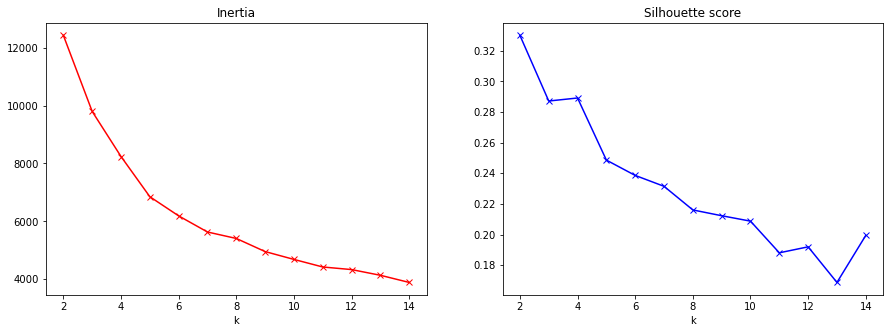

In [8]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

## User-defined values

In [9]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

# Fit and classify using k-means

In [10]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 97 (50.79%)
Class 1 (red): 27 (14.14%)
Class 2 (cyan): 63 (32.98%)
Class 3 (orange): 4 (2.09%)


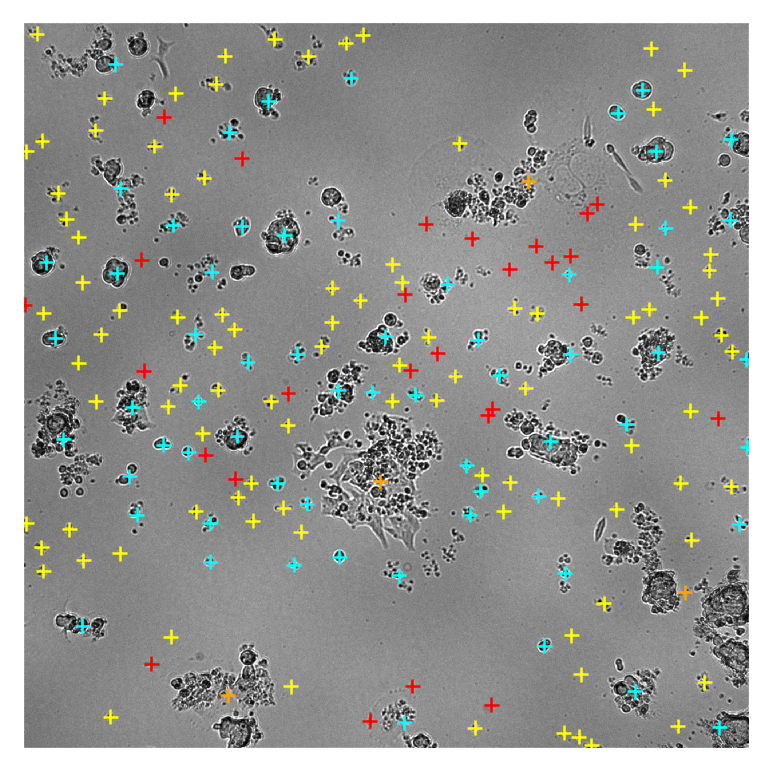

In [11]:
display_classifications(image_gray, df.index, labels)

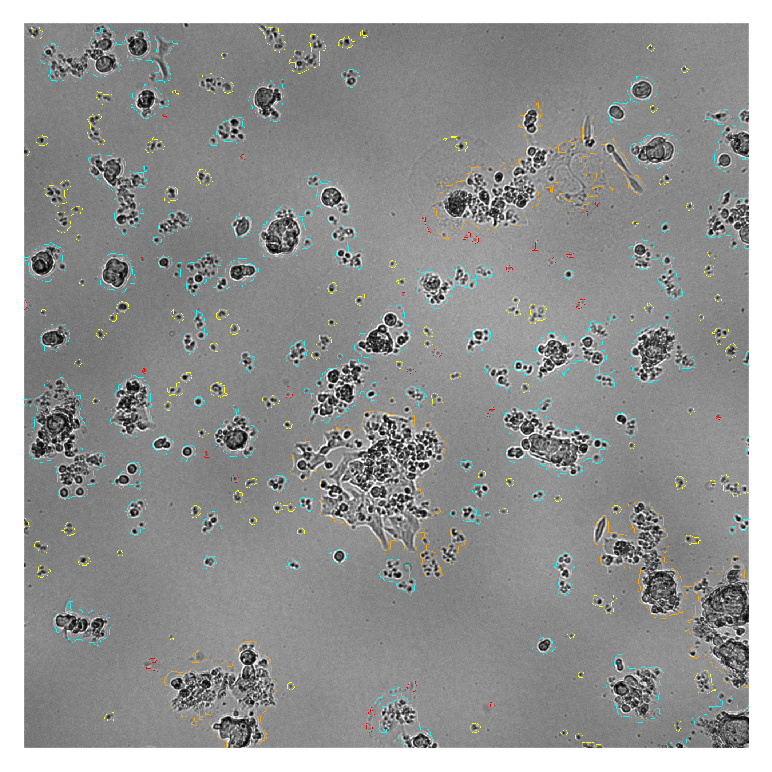

In [12]:
display_contours(image_gray, masks, labels)

In [13]:
# display_rois(image_gray, masks, labels)

# Visualize clusters with t-SNE

Unfortunately `sklearn` doesn't let us set a colormap here, so the colors aren't consistent.

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


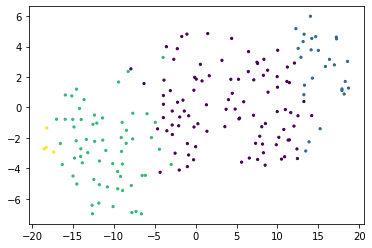

In [14]:
display_tsne(df)

# Quantify fluorescence within clusters

## Binary analysis

In [15]:
# fluorescence_binarized = \
#     get_mask_image(image_fluorescent, 'params_fluorescence.yml', verbosity=1)

In [16]:
# display_fluorescence(fluorescence_binarized, masks, labels)

## Intensity analysis

In [17]:
# display_fluorescence(image_fluorescent, masks, labels)

## Class-wise analysis

In [18]:
# statistics = [[]] * len(np.unique(labels))

# column_labels = ["mode", "median", "max", "min", "range", "75th", "IQR"]

# for i in range(len(masks)):
#     intensities = image_fluorescent.flatten()[np.argwhere(masks[i].flatten()).flatten()]
#     s, c = np.unique(intensities, return_counts=True)
#     # can't use += here, will cause wonky behavior
#     statistics[labels[i]] = statistics[labels[i]] + \
#                             [[s[np.argmax(c)],  # returns the first mode
#                              np.median(intensities),
#                              np.max(intensities),
#                              np.min(intensities),
#                              np.max(intensities) - np.min(intensities),
#                              np.percentile(intensities, 75),
#                              np.percentile(intensities, 75) - np.percentile(intensities, 25)],]
    
# for i in range(len(statistics)):
#     # must convert to numpy array before passing to pandas, or will infer wrong types
#     statistics[i] = pd.DataFrame(np.array(statistics[i]),
#                                  columns=column_labels)
    
#     print("Class %i" % i)
#     fig, axs = plt.subplots(1, len(column_labels), figsize=(18,2))
#     for j in range(len(column_labels)):
#         c = column_labels[j]
#         axs[j].hist(statistics[i][c], bins=16, range=(0,256))
#         axs[j].set_title(c)
#         axs[j].set_xlim([0,256])
#     plt.show()

### Kruskal-Wallis H tests

In [19]:
# for c in column_labels:
#     try:
#         print("%s:\tpvalue=%s" % (c, stats.kruskal(*[k[c].values for k in statistics])[1]))
#     except ValueError:
#         print("%s:\tvalues identical" % c)
#         continue
#     for i in range(len(statistics)):
#         for j in range(i+1, len(statistics)):
#             try:
#                 pval = stats.kruskal(statistics[i][c].values, statistics[j][c].values)[1]
#             except ValueError:
#                 print("  %i,%i:\tvalues identical" % (i, j))
#                 continue
#             if pval >= 0.05:
#                 print("  %i,%i:\tpvalue=%.10f" % (i, j, pval))

# Classify whole image stack

## Extract raw features in parallel

`get_mask_image` and `extract_features` are the most computationally expensive operations, and conveniently are also very easy to parallelize.

This cuts down runtime by ~50%. Note that `tqdm` tracks process initiation, not completion, but this is a cheap and easy way to track progress.

In [20]:
def ef_parallel(image_gray):
    mask_image = get_mask_image(image_gray, 'params_gray_mask.yml')
    df, masks = extract_features(image_gray, mask_image)
    return mask_image, df, masks

In [21]:
gray_images = image_stack[1::3]

result = Parallel(n_jobs=cpu_count())(delayed(ef_parallel)(ig) for ig in tqdm(gray_images))

100%|██████████████████████████████████████████████| 94/94 [39:46<00:00, 25.39s/it]


## Process features and cluster using k-means

This expects that the models have been trained in the cells above - we'll re-transform the first image but that's okay.

Image 0:


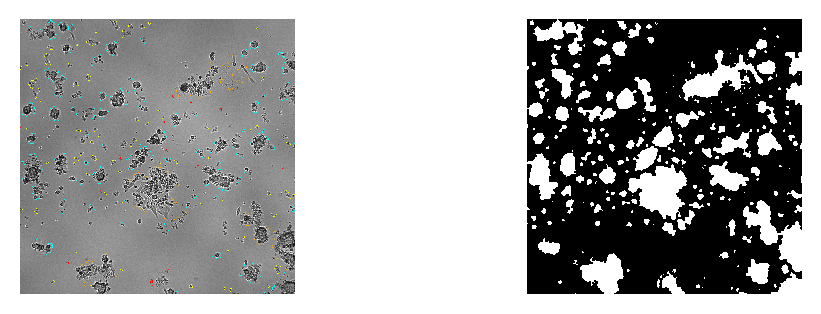

Image 3:


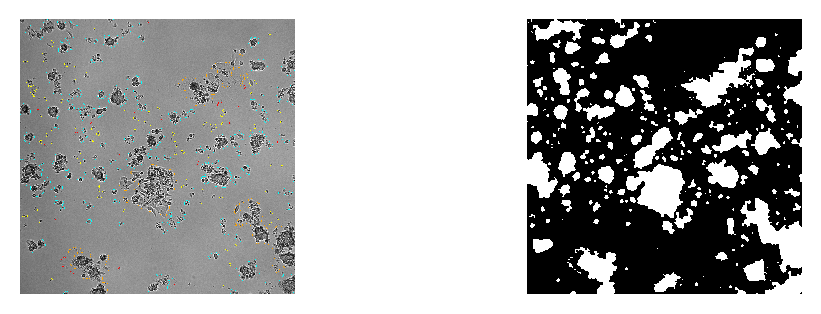

Image 6:


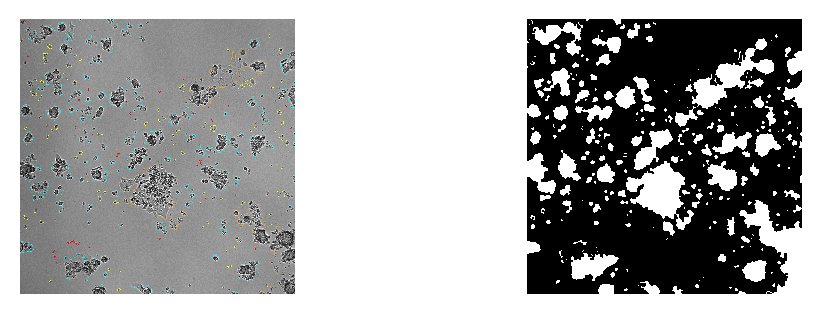

Image 9:


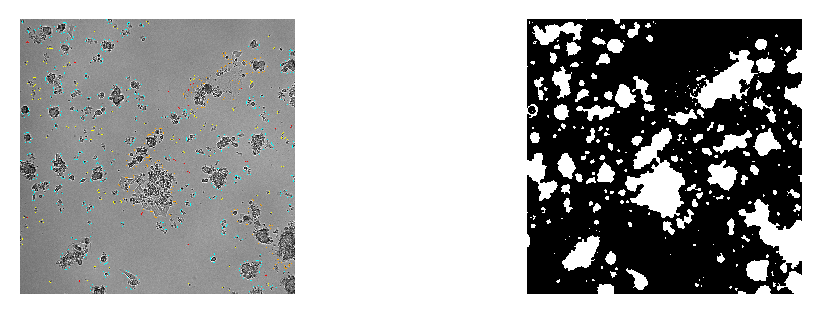

Image 12:


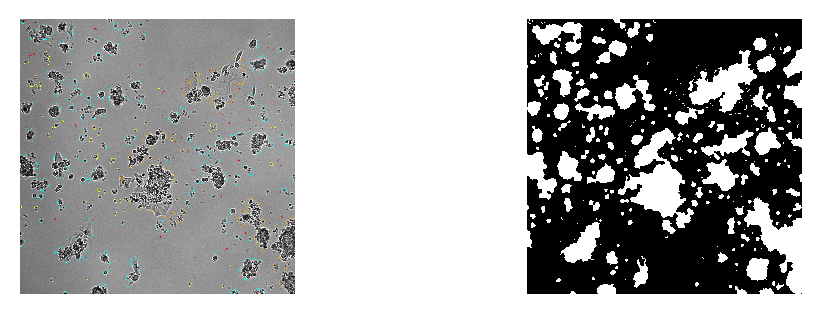

Image 15:


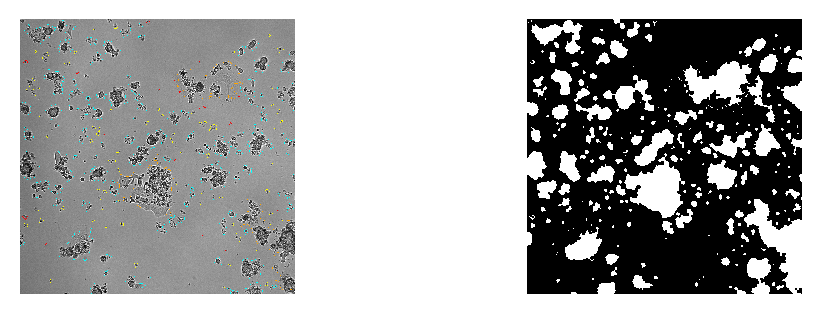

Image 18:


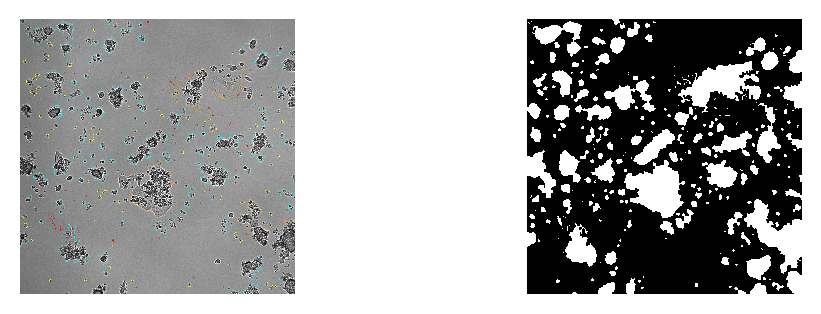

Image 21:


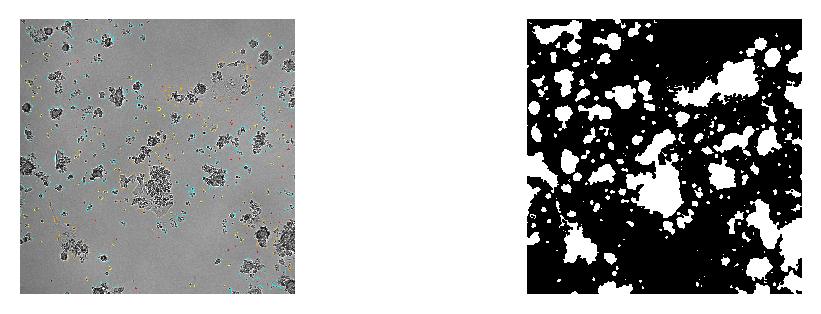

Image 24:


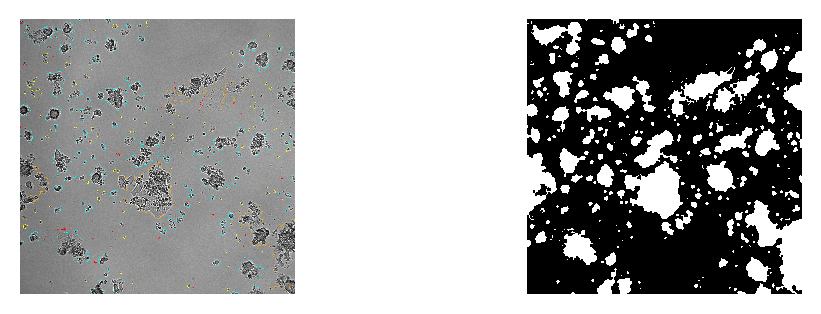

Image 27:


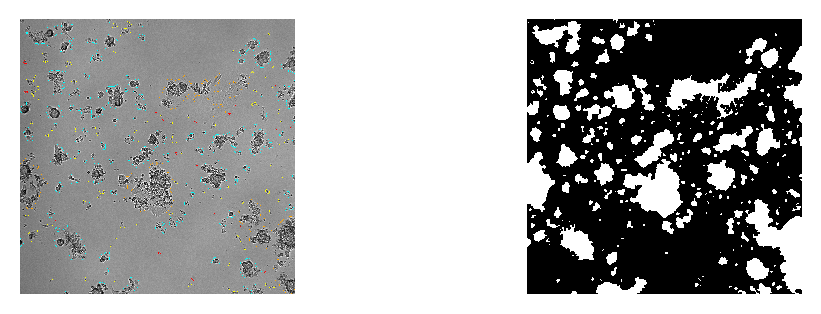

Image 30:


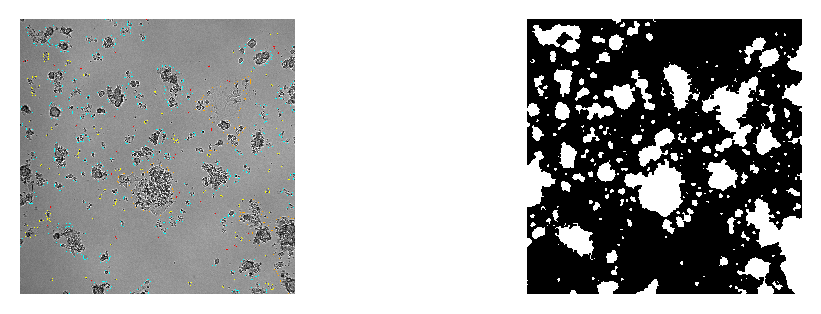

Image 33:


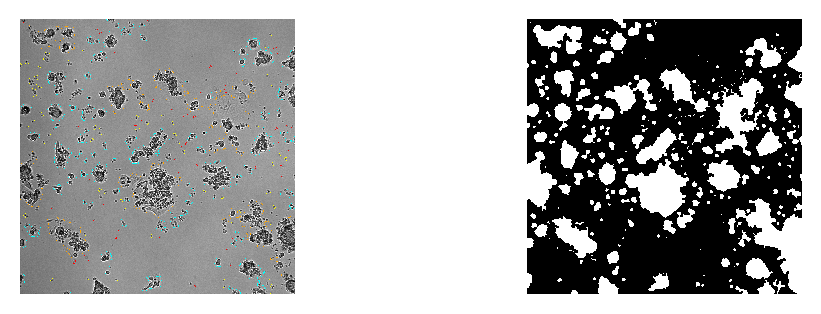

Image 36:


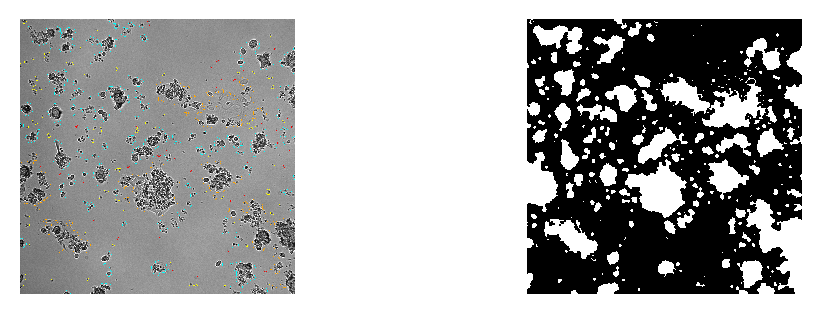

Image 39:


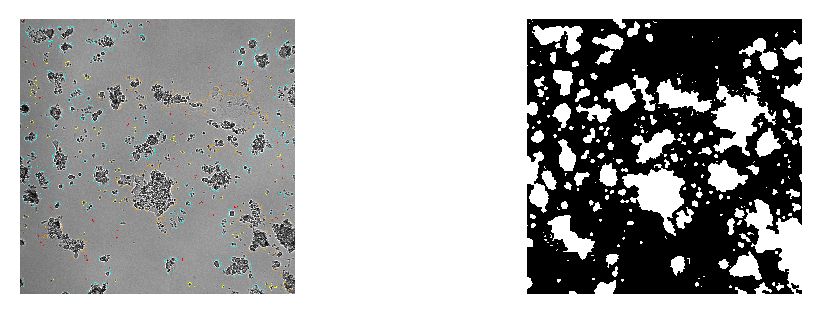

Image 42:


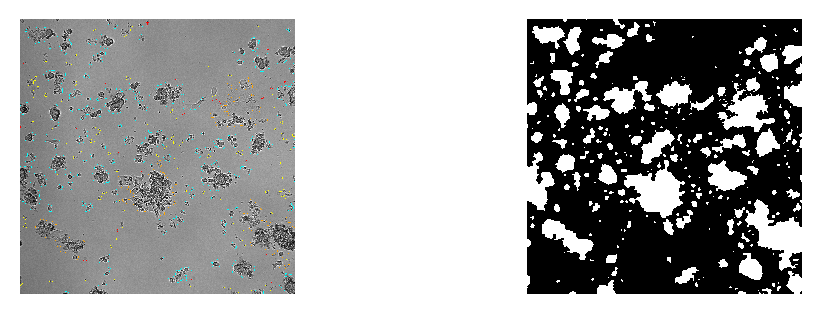

Image 45:


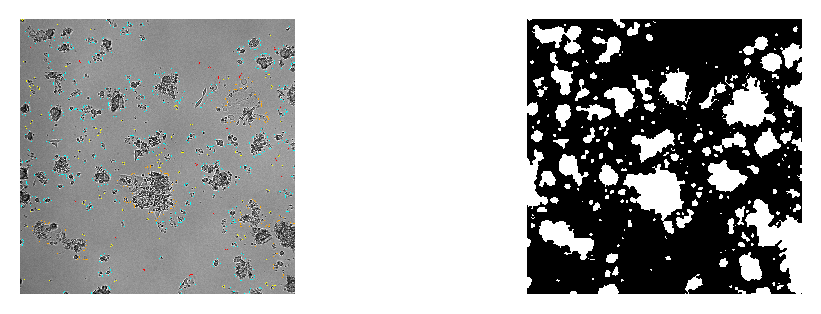

Image 48:


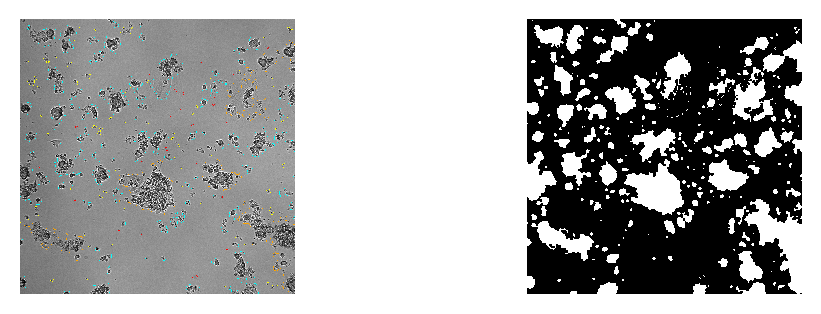

Image 51:


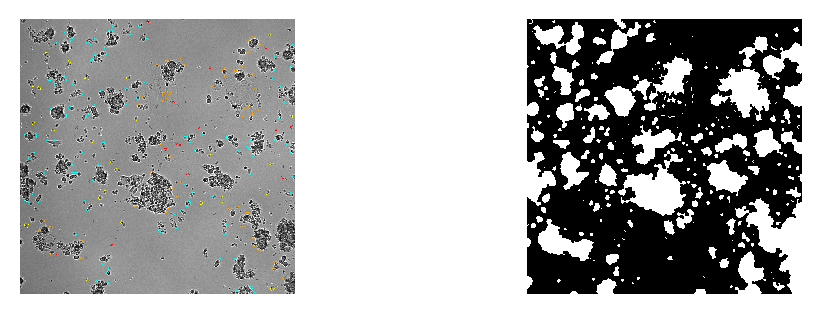

Image 54:


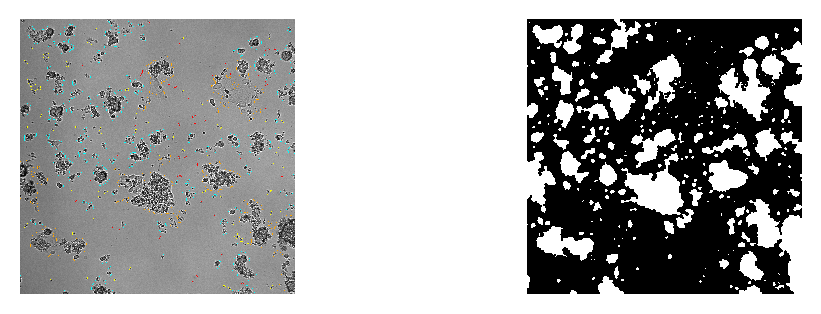

Image 57:


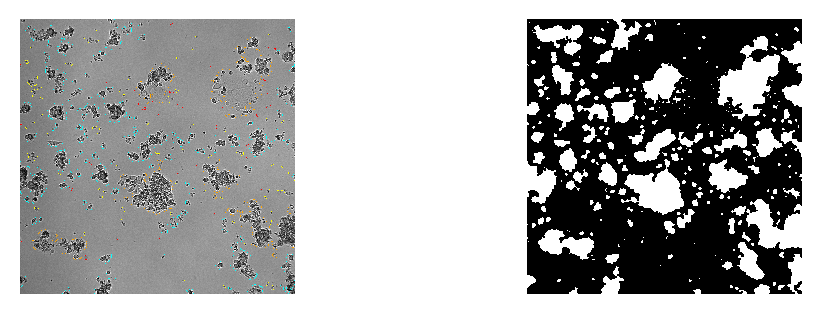

Image 60:


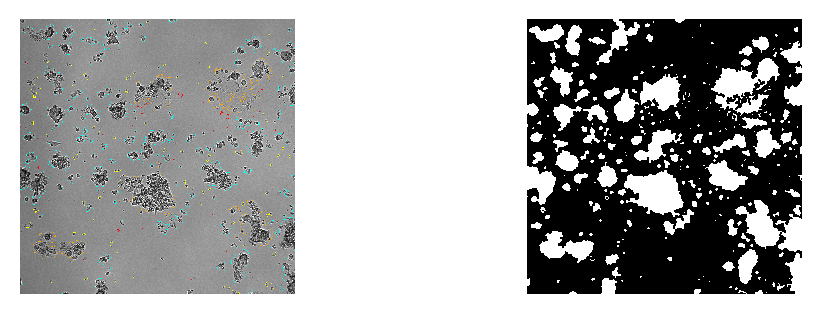

Image 63:


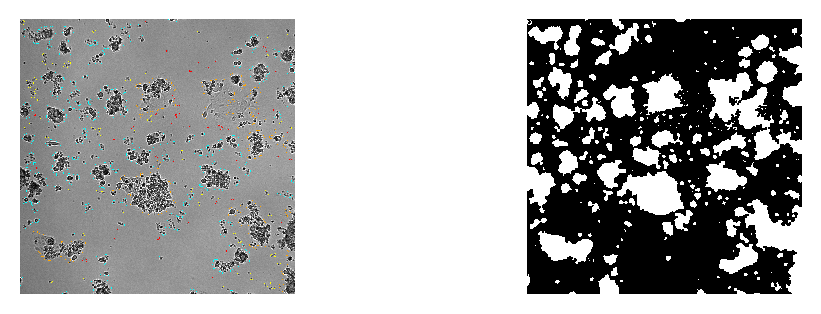

Image 66:


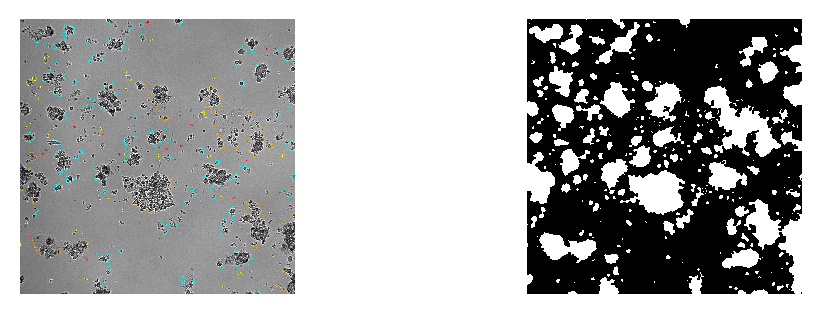

Image 69:


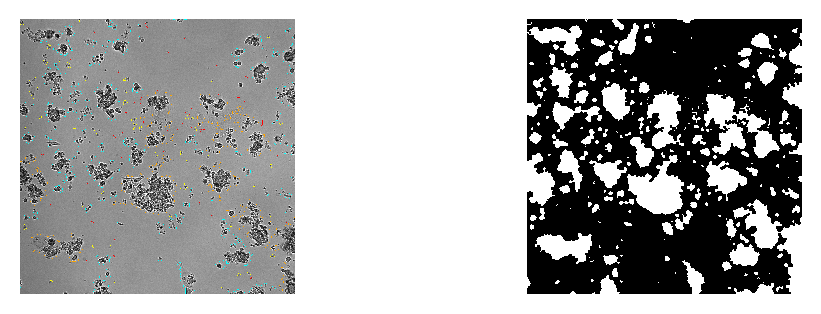

Image 72:


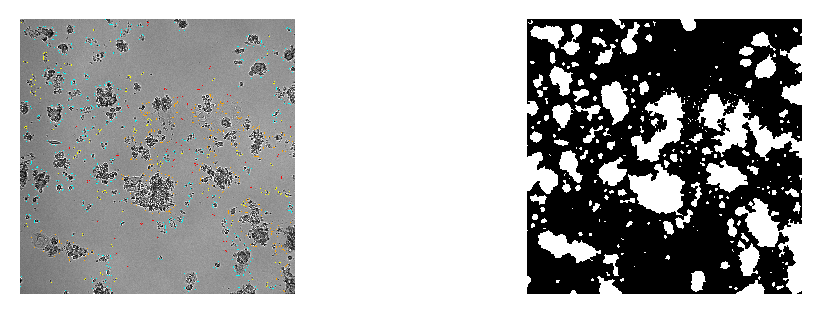

Image 75:


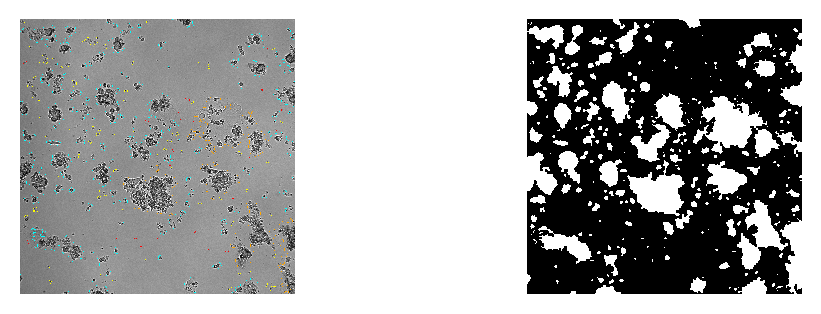

Image 78:


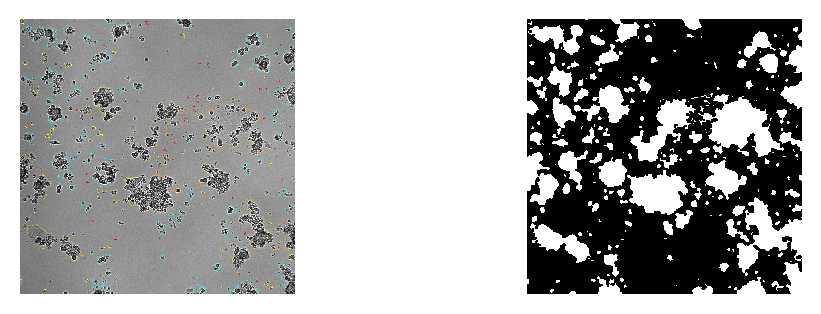

Image 81:


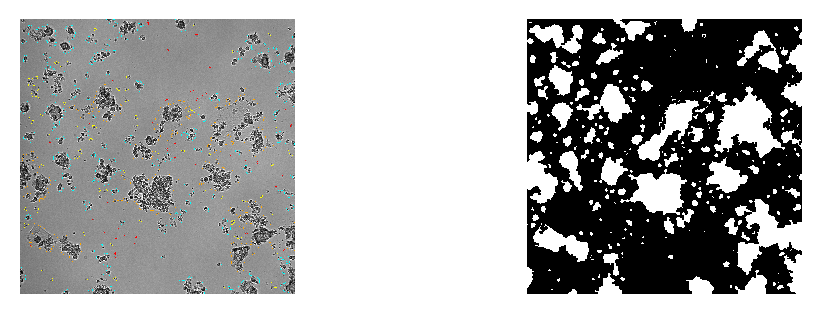

Image 84:


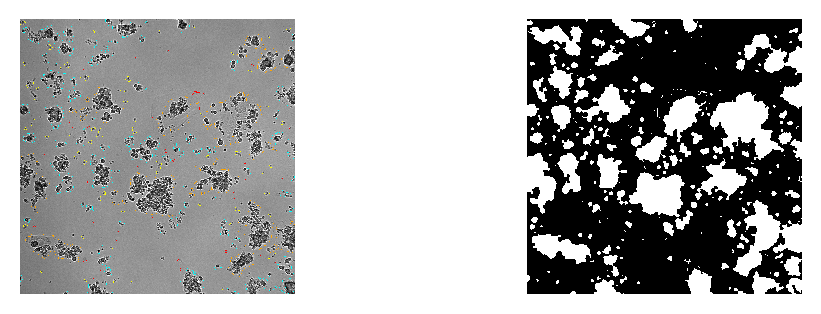

Image 87:


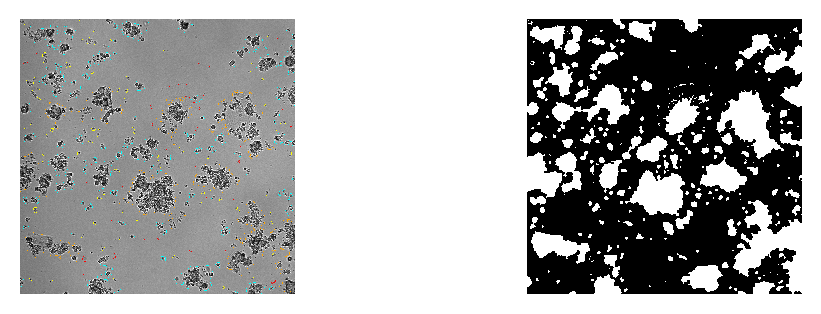

Image 90:


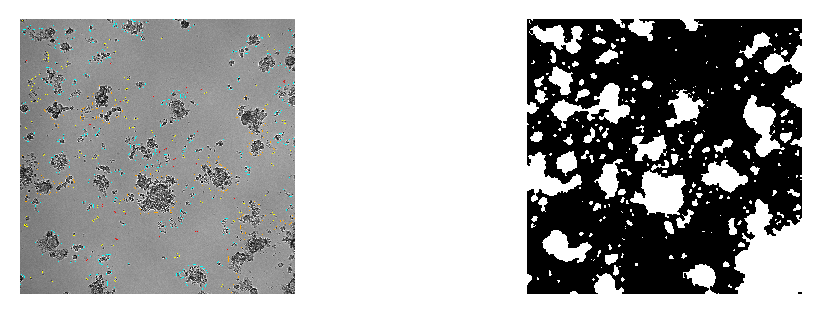

Image 93:


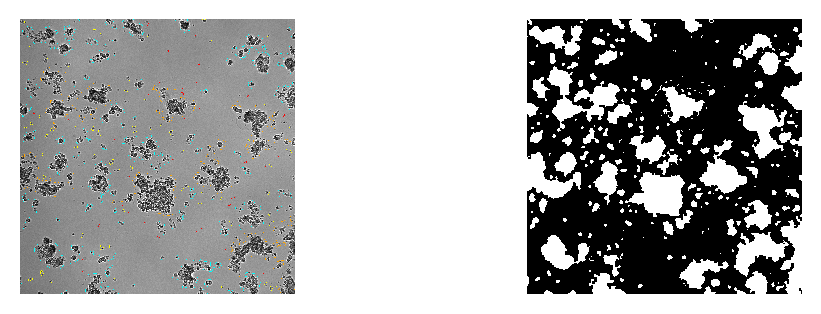

In [22]:
counts = []

for i in range(len(result)):
    mask_image, df, masks = result[i]

    # Preprocess features
    scaled = scaler.transform(df.to_numpy(dtype=np.float64))
    reduced = pca.transform(scaled)
    df = pd.DataFrame(reduced, index=df.index)
    
    # Cluster using k-means
    labels = kmeans.predict(df)
    
    counts += [[a[1] for a in sorted(Counter(labels).items(), key=lambda a: a[0])],]
    
    # Display sanity check images
    if i % 3 == 0:
        print("Image %i:" % i)
        contour_image = display_contours(gray_images[i], masks, labels, ret_image=True)
        display_image_array([contour_image, mask_image], columns=2, dpi=200)

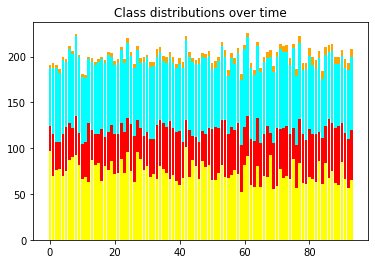

In [23]:
bottom = np.zeros(len(counts))
class_counts = np.array(counts).T

for i in range(len(class_counts)):
    c = class_counts[i]
    plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[i])
    plt.title("Class distributions over time")
    bottom += c